In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from scipy.interpolate import interp1d
from scipy import optimize

from interaction import potential, LocalSystem
from counterterm import local_LO_counterterm
from constants import MU, BETA4, A0_MM
import scattering_length as sl

plt.style.use('science')
ratio = 4/3
h = 3

In [2]:
GUESS = np.array([1.19175560e-01, 1.83340712e-03, -9.86485552e-01, -2.00617369e+01])

nR = 100
ratios = np.linspace(30, 80, nR)
Rs = BETA4/ratios

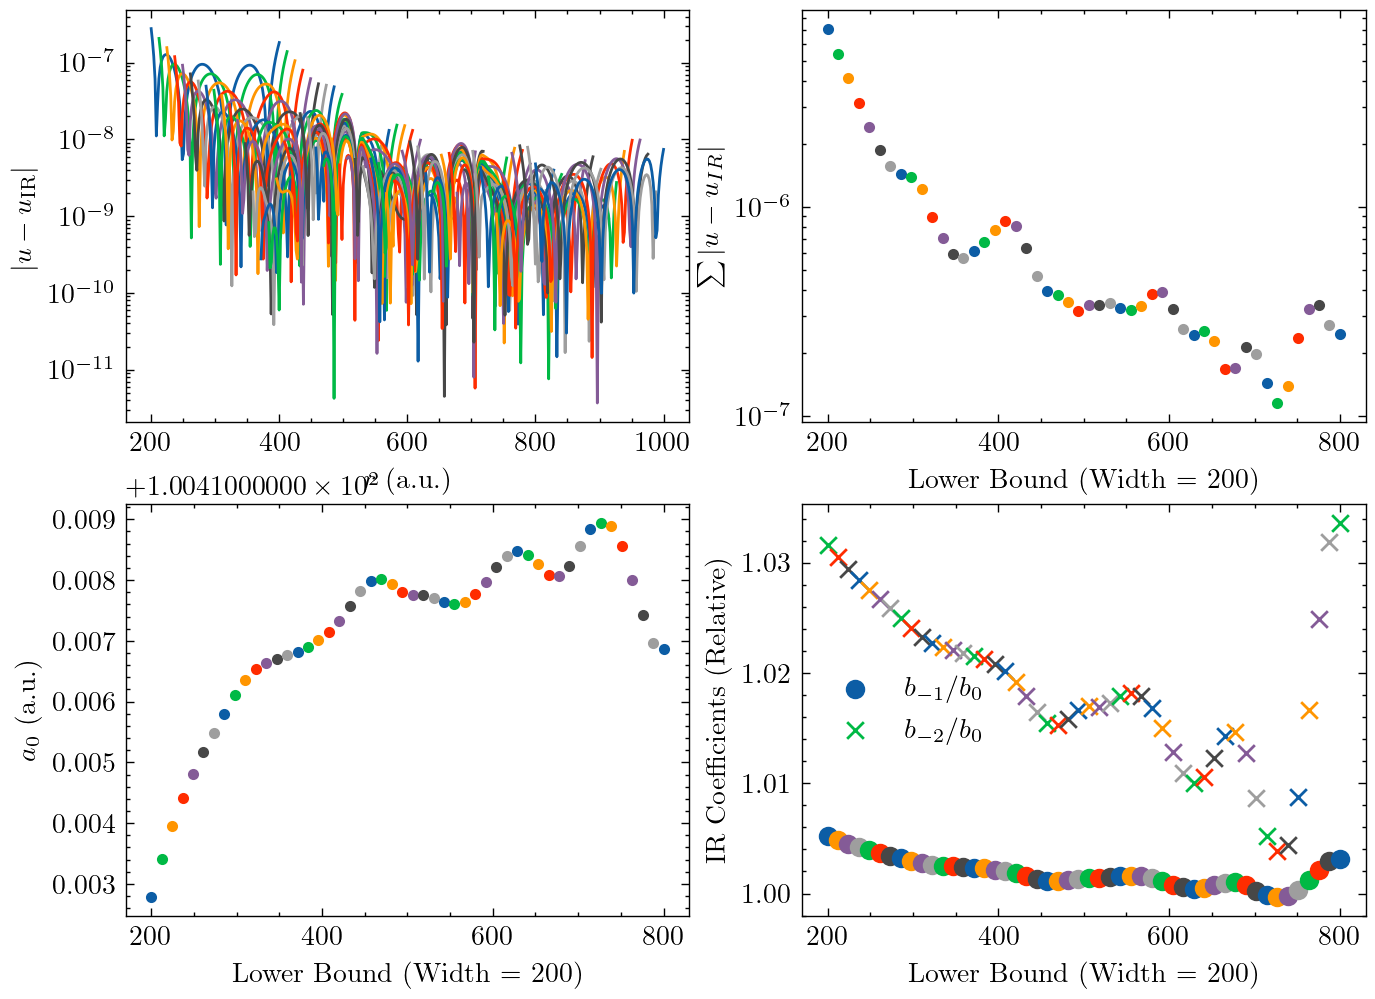

In [4]:
index = 0
Ri = Rs[index]
gi = 0
pot = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)

width = 200
lower_bounds = np.linspace(200, 800, 50)

ir1_label = r'$b_{-1}/b_0$'
ir2_label = r'$b_{-2}/b_0$'

fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=200)
fig.patch.set_facecolor('white')

sol = sl.wave_function(pot, 0, r_endpts=[1e-3, 2000])
guess = GUESS.copy()

for lb in lower_bounds:
    
    rs = np.linspace(lb, lb + width, 100)
    u = sol(rs)[0]

    a0, ir1_ratio, ir2_ratio, bs = sl.fit_i4_a0(u, rs, guess)
    guess = bs.copy()
    
    residuals = np.abs(u - sl.i4_tail(rs, *bs))
    res_sum = np.sum(residuals)
    
    ax[0, 0].plot(rs, residuals)
    ax[0, 0].set_xlabel(rf'$r$ (a.u.)')
    ax[0, 0].set_ylabel(r'$|u - u_{\rm IR}|$')
    ax[0, 0].set_yscale('log')
    
    ax[0, 1].scatter(lb, res_sum, marker='.')
    ax[0, 1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[0, 1].set_ylabel(r'$\sum|u - u_{IR}|$')
    ax[0, 1].set_yscale('log')
    
    ax[1, 0].scatter(lb, a0, marker='.')
    ax[1, 0].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1, 0].set_ylabel(r'$a_0$ (a.u.)')
    
    ax[1, 1].scatter(lb, ir1_ratio, marker='o', label=ir1_label)
    ax[1, 1].scatter(lb, ir2_ratio, marker='x', label=ir2_label)
    ax[1, 1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1, 1].set_ylabel(r'IR Coefficients (Relative)')
    
    ir1_label = None
    ir2_label = None

ax[1, 1].legend();

In [5]:
rs = np.linspace(500, 600, 100)

In [6]:
@dataclass
class Coefficients:
    '''
    Stores coefficients to IR-corrected, zero-energy, 1/r^4 wave function:
    u_{IR}(r) = b_0 + b_1 r + b_{-1} / r + b_{-2} / r^2
    '''
    b_0 : float
    b_1 : float
    b_m1 : float
    b_m2 : float
        
    def a_0(self):
        return -self.b_0 / self.b_1
    
    
    def b_m1_scaled(self):
        return self.b_m1 / self.b_0

    
    def b_m2_scaled(self):
        return self.b_m2 / self.b_0
    
    
    def b_m1_predicted(self):
        return BETA4**2/(2*self.a_0())
    
    
    def b_m2_predicted(self):
        return -BETA4**2/6
    

In [7]:
def extract_coeffs(pot, p0):
    u = sl.wave_function(pot, 0)(rs)[0]
    _, _, _, coeffs = sl.fit_i4_a0(u, rs, guess=p0)
    return coeffs
    
def diff(g, R, p0):
    pot = lambda r: potential(r, R) + g*local_LO_counterterm(r, R)
    b0, b1, _, _ = extract_coeffs(pot, p0)
    a0 = -b0/b1
    
    return (A0_MM - a0)/A0_MM

In [8]:
g0 = -0.7625
diff(g0, Ri, guess)

0.008754941491024555

In [9]:
s = LocalSystem(Ri)
s.bound_state_spectrum(g0, 0).size

14

In [10]:
results = []
coeffs = []
p0 = GUESS.copy()

for i in tqdm(range(nR)):
    Ri = Rs[i]
    
    if i > 10:
        x = np.array(results)[-5:, 0]
        y = np.array(results)[-5:, 1]
        f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
        g0 = f(Ri)
    
    c0 = optimize.fsolve(diff, g0, args=(Ri, p0))[0]
    g0 = c0
    
    pot = lambda r: potential(r, Ri) + c0*local_LO_counterterm(r, Ri)
    pars = extract_coeffs(pot, p0)
    p0 = pars
    
    coeffs.append(Coefficients(*pars))
    results.append([Ri, c0])

 16%|█████████████▌                                                                       | 16/100 [00:04<00:20,  4.09it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 77%|█████████████████████████████████████████████████████████████████▍                   | 77/100 [00:27<00:16,  1.41it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 85%|████████████████████████████████████████████████████████████████████████▎            | 85/100 [00:34<00:12,  1.16it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpa

ValueError: array must not contain infs or NaNs

In [11]:
results = np.array(results)

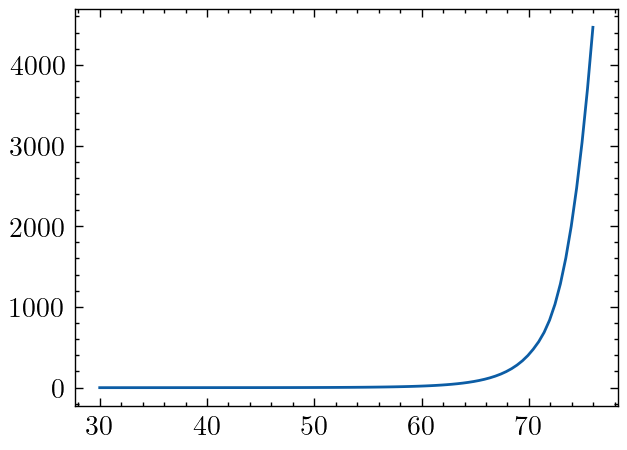

In [12]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/results[:, 0], results[:, 1])

# ax.set_ylim([-10, 1000])
# ax.set_yscale('log');

In [13]:
a0s = np.array([c.a_0() for c in coeffs])

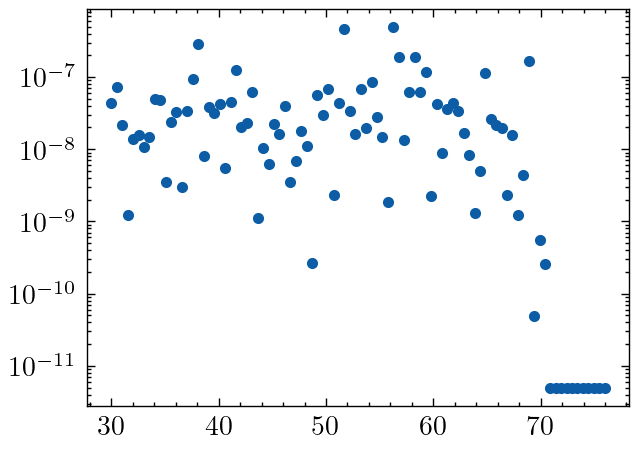

In [17]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(BETA4/results[:, 0], np.abs((A0_MM - a0s)/A0_MM), marker='.')
ax.set_yscale('log');
# ax.axhline(A0_MM, color='C1', linestyle='--');

In [18]:
ii = np.where(np.abs((A0_MM - a0s)/A0_MM) < 1e-6)[0]

In [20]:
ii, ii.size

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91]),
 92)

In [21]:
np.savetxt('datfiles/rg_flows/rg_flow_lo_n_14.txt', results[ii, :])